In [64]:
import json
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import pandas as pd
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [65]:
class WSIEmbeddingsDataset(Dataset):
    def __init__(self, base_dir="cases"):
        self.metadata = []
        self.slide_stats_df = pd.read_csv(f"{base_dir}/slide_statistics.csv")
        case_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

        if "GENERAL_METADATA" in case_dirs:
            case_dirs.remove("GENERAL_METADATA")

        for case_id in case_dirs:
            case_dir = os.path.join(base_dir, case_id)
            metadata_path = os.path.join(case_dir, "aggregated_data", f'{case_id}_data.json')

            if not os.path.exists(metadata_path):
                print(f"No metadata found for case {case_id}, skipping...")
                continue
            
            with open(metadata_path, 'r') as f:
                case_metadata = json.load(f)

            if case_metadata["biospecimen"]["has_data"] == False or \
                case_metadata["clinical"]["has_data"] == False or \
                case_metadata["methylation"]["has_data"] == False:
                continue
            
            for sample in case_metadata["biospecimen"]["biospecimen_data"]:
                if sample["sample_type"] == "Primary Tumor":
                    for slide in sample["slides"]:
                        slide_barcode = slide["slide_barcode"]
                        
                        if slide["resolution_level"] > 2:
                            censored = 0
                            survival_time = case_metadata["clinical"]["clinical_patient_data"].get("days_to_death")
                            
                            if survival_time is None:
                                survival_time = case_metadata["clinical"]["clinical_patient_data"].get("days_to_last_followup")
                                censored = 1

                            if survival_time is None:
                                print(f"Skipping slide {slide_barcode} from case {case_id} due to missing survival data.")
                                continue  # Skip slides with no survival data

                            self.metadata.append({
                                "case_id": case_id,
                                "slide_barcode": slide_barcode,
                                "embedding": slide["embedding"],
                                "survival_time": float(survival_time),
                                "censored": 1-censored
                            })
                        else:
                            print(f"Skipping slide {slide_barcode} from case {case_id} due to insufficient or missing resolution.")
    
    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        item = self.metadata[index]
        embedding_tensor = torch.tensor(item["embedding"], dtype=torch.float32)
        survival_time = item["survival_time"]
        censored = item["censored"]
        return embedding_tensor, (survival_time, censored)

In [66]:
class SurvivalNN(nn.Module):
    def __init__(self, embedding_size):
        super(SurvivalNN, self).__init__()
        
        # Define a simple feedforward neural network
        self.fc1 = nn.Linear(embedding_size + 2, 64)  # +2 for survival time and censored
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output single value for survival prediction

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [67]:
dataset = WSIEmbeddingsDataset(base_dir="cases_TEST_TRAIN_100")
all_data = DataLoader(dataset)

Skipping slide TCGA-AA-3524-01A-01-BS1 from case 03efbc94-a43d-4db0-9377-e397348430a6 due to insufficient or missing resolution.
Skipping slide TCGA-AA-3524-01A-02-BS2 from case 03efbc94-a43d-4db0-9377-e397348430a6 due to insufficient or missing resolution.
Skipping slide TCGA-AA-3521-01A-01-BS1 from case ad440651-a2de-4bb1-90da-1e5e8975ab59 due to missing survival data.
Skipping slide TCGA-AA-3521-01A-01-TS1 from case ad440651-a2de-4bb1-90da-1e5e8975ab59 due to missing survival data.
Skipping slide TCGA-AA-3950-01A-02-BS2 from case cc53bf9e-5e27-4305-a08b-552120c10aa5 due to insufficient or missing resolution.
Skipping slide TCGA-AA-3662-01A-01-BS1 from case d9fb85c3-ade1-47bf-8159-170f81eb130f due to insufficient or missing resolution.
Skipping slide TCGA-AA-3662-01A-01-TS1 from case d9fb85c3-ade1-47bf-8159-170f81eb130f due to insufficient or missing resolution.
Skipping slide TCGA-AA-3556-01A-01-TS1 from case fd16b634-2e04-44a3-862d-fb03cd73c057 due to insufficient or missing resolu

In [71]:
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

# for batch_idx, (embedding_tensor, (survival_time, censored)) in enumerate(train_loader):
#     print(f"Batch {batch_idx + 1}:")
#     print(f"Type of survival_time: {type(survival_time)}")
#     print(f"Type of censored: {type(censored)}")
#     print(f"Survival Time: {survival_time}")
#     print(f"Censored Value: {censored}")
#     print('-' * 50)

embedding_size = 2048
num_nodes = [256, 128]
dropout = 0.1

net = tt.practical.MLPVanilla(embedding_size, num_nodes, 1, batch_norm=False, dropout=dropout)

model = CoxPH(net, tt.optim.Adam)

optimizer = tt.optim.Adam(lr=0.001)
model.optimizer = optimizer

# After training the model
log = model.fit_dataloader(
    train_loader,  
    epochs=10,
    callbacks=[tt.callbacks.EarlyStopping(patience=5)]
)

# Step 2: Collect Data for the Entire Dataset
features_list = []
survival_times = []
censored = []

for embeddings, (survival_time, censored_value) in train_loader:
    features_list.append(embeddings.numpy())  # Collect features (embeddings)
    survival_times.extend(survival_time.tolist())  # Collect survival times
    censored.extend(censored_value.tolist())  # Collect censoring info

surv = model.predict_surv_df(features_list)
surv.head()


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	


ValueError: Need to compute baseline_hazards_. E.g run `model.compute_baseline_hazards()`

<lifelines.CoxPHFitter: fitted with 66 total observations, 11 right-censored observations>
             duration col = 'survival_time'
                event col = 'event_occurred'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 66
number of events observed = 55
   partial log-likelihood = -104.73
         time fit was run = 2025-01-22 14:26:21 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
feature_6    -0.12      0.89      2.89           -5.78            5.54                0.00              255.18
feature_16    5.62    275.78      9.12          -12.25           23.49                0.00            1.60e+10
feature_23   -0.68      0.51      6.65          -13.72           12.36                0.00            2.34e+05
feature_41    2.69     14.79      2.79           -2.78            8.17                0.06             3538.61
feature_71    4.37     79.26      6.60           -8.56           17.30                0.00            3.27e+07
feature_76    0.19      1.20      8.31          -16.10           16.47                0.00            1.43e+07
feature_78   -0.77      0.46      7.64          -15.75           14.20                0.00            1.47e+06
feature_83    0.86      2.37      6.07          -11.03           12.76                0.00            3.48e+05
feature_94   -1.08      0.34      2.10           -5.20            3.03                0.01               20.64
feature_97   -0.82      0.44      2.01           -4.77            3.13                0.01               22.80
feature_99    1.30      3.66     10.16          -18.62           21.21                0.00            1.63e+09
feature_110  -0.43      0.65      9.04          -18.14           17.28                0.00            3.20e+07
feature_113  -0.19      0.83      2.13           -4.36            3.98                0.01               53.43
feature_137   3.63     37.59      4.59           -5.38           12.63                0.00            3.06e+05
feature_144  -5.22      0.01      6.89          -18.72            8.28                0.00             3948.16
feature_152   0.98      2.67      2.05           -3.04            5.00                0.05              148.11
feature_175   0.39      1.47      9.81          -18.83           19.61                0.00            3.27e+08
feature_189   6.41    610.81      9.40          -12.00           24.83                0.00            6.07e+10
feature_193   0.42      1.52      5.45          -10.26           11.10                0.00            66260.18
feature_198   4.19     65.98      6.91           -9.35           17.73                0.00            5.02e+07
feature_209  -7.34      0.00      5.94          -18.98            4.29                0.00               72.81
feature_234  -0.70      0.49      9.81          -19.93           18.52                0.00            1.11e+08
feature_239  -0.69      0.50      3.59           -7.72            6.35                0.00              570.45
feature_241   1.63      5.10      6.65          -11.41           14.67                0.00            2.35e+06
feature_248   1.77      5.87      5.47           -8.95           12.49                0.00            2.66e+05
feature_254  -3.87      0.02      6.00          -15.64            7.89                0.00             2680.34
feature_257  -1.24      0.29      7.22          -15.39           12.92                0.00            4.07e+05
feature_263  -0.25      0.78      7.50          -14.94           14.44                0.00            1.87e+06
feature_268   0.84      2.31      9.81          -18.38           20.06                0.00            5.16e+08
feature_282   1.89      6.60      7.95          -13.69           17.47                0.00            3.85e+07
feature_294 

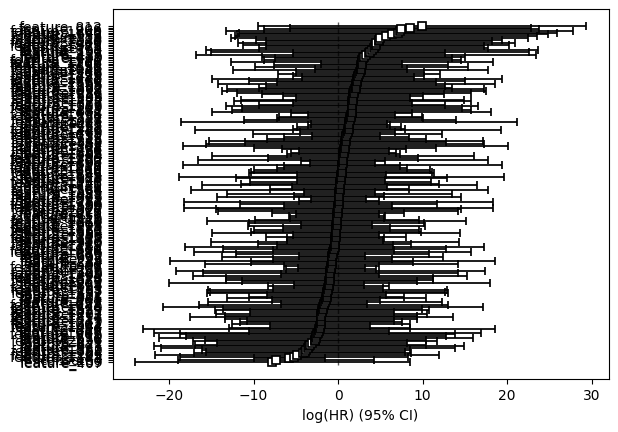

IndexError: index -1 is out of bounds for axis 0 with size 0

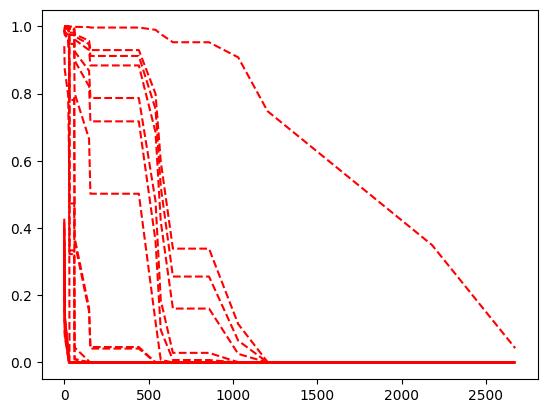

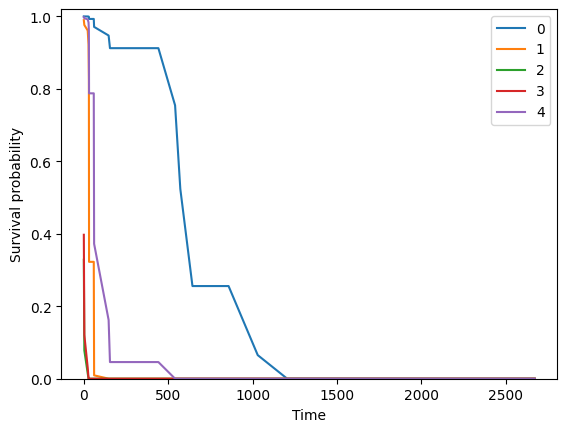

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from lifelines import CoxPHFitter
from SurvivalEVAL.Evaluator import LifelinesEvaluator

# Step 1: Initialize your model
cph = CoxPHFitter(penalizer=0.01)

# Step 2: Collect Data for the Entire Dataset
features_list = []
survival_times = []
censored = []

for embeddings, (survival_time, censored_value) in train_loader:
    features_list.append(embeddings.numpy())  # Collect features (embeddings)
    survival_times.extend(survival_time.tolist())  # Collect survival times
    censored.extend(censored_value.tolist())  # Collect censoring info

# Step 3: Convert list of features to DataFrame
all_features = pd.DataFrame([item for sublist in features_list for item in sublist], 
                            columns=[f"feature_{i}" for i in range(features_list[0].shape[1])])

# Step 4: Add survival time and censoring info to the DataFrame
all_features['survival_time'] = survival_times
all_features['censored'] = censored
all_features['event_occurred'] = all_features['censored'].apply(lambda x: 1 if x == 0 else 0)  # Invert censored values

# Step 5: Apply VarianceThreshold to remove low variance features
X = all_features.iloc[:, :-3]  # Exclude 'survival_time' and 'censored' columns
y = all_features.iloc[:, -3:]   # 'survival_time' and 'censored'

# Apply VarianceThreshold (threshold can be adjusted)
selector = VarianceThreshold(threshold=0.01)
X_high_variance = selector.fit_transform(X)

# Step 6: Convert the selected features back into a DataFrame
X_high_variance_df = pd.DataFrame(X_high_variance, columns=X.columns[selector.get_support()])

# Step 7: Concatenate the selected features with survival time and censoring columns
combined_df_cleaned = pd.concat([X_high_variance_df, y], axis=1)

# Step 8: Fit the Cox Proportional Hazards model on the cleaned DataFrame
cph.fit(combined_df_cleaned, duration_col='survival_time', event_col='event_occurred')

# Step 9: Model Summary
cph.print_summary()

# Step 10: Plot the Survival Function
cph.plot()
plt.show()

predicted_survival_curves = cph.predict_survival_function(combined_df_cleaned)

# Plot the survival curves for a few individuals
for i in range(len(predicted_survival_curves)):  # First 5 individuals
    predicted_survival_curves.iloc[:, i].plot(label=f"Predicted Survival - Sample {i + 1}", color='red', linestyle='--')

evl = LifelinesEvaluator(predicted_survival_curves, combined_df_cleaned['survival_time'], combined_df_cleaned['event_occurred'])
evl.plot_survival_curves(curve_indices=[0, 1, 2, 3, 4])  # Plot the survival curves for the first 5 individuals

cindex, correct_pairs, total_pairs = evl.concordance() # needs the actual values to be put into the evaluator
print("C-index: {:.4f}; \nNumber of correctly ordered pairs: {}; \nNumber of total comparable pairs: {}.".format(cindex, correct_pairs, total_pairs))


Skipping slide TCGA-AA-3524-01A-01-BS1 from case 03efbc94-a43d-4db0-9377-e397348430a6 due to insufficient or missing resolution.
Skipping slide TCGA-AA-3524-01A-02-BS2 from case 03efbc94-a43d-4db0-9377-e397348430a6 due to insufficient or missing resolution.
Skipping slide TCGA-AA-3521-01A-01-BS1 from case ad440651-a2de-4bb1-90da-1e5e8975ab59 due to missing survival data.
Skipping slide TCGA-AA-3521-01A-01-TS1 from case ad440651-a2de-4bb1-90da-1e5e8975ab59 due to missing survival data.
Skipping slide TCGA-AA-3950-01A-02-BS2 from case cc53bf9e-5e27-4305-a08b-552120c10aa5 due to insufficient or missing resolution.
Skipping slide TCGA-AA-3662-01A-01-BS1 from case d9fb85c3-ade1-47bf-8159-170f81eb130f due to insufficient or missing resolution.
Skipping slide TCGA-AA-3662-01A-01-TS1 from case d9fb85c3-ade1-47bf-8159-170f81eb130f due to insufficient or missing resolution.
Skipping slide TCGA-AA-3556-01A-01-TS1 from case fd16b634-2e04-44a3-862d-fb03cd73c057 due to insufficient or missing resolu

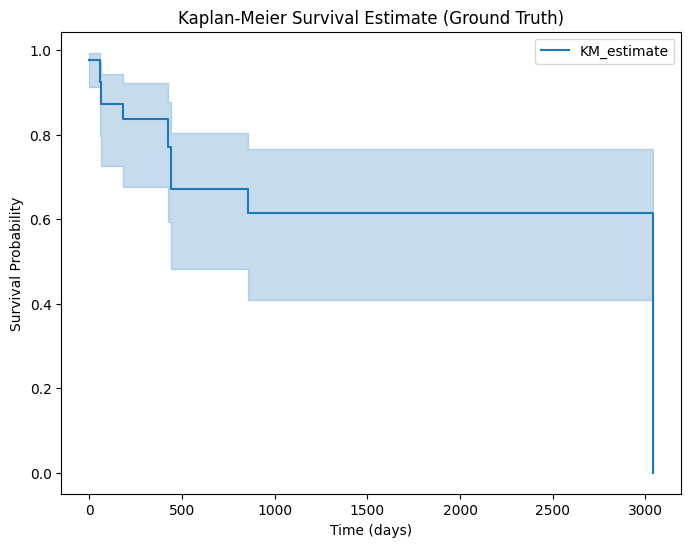

In [ ]:
from lifelines import KaplanMeierFitter
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from SurvivalEVAL.Evaluator import LifelinesEvaluator

# Instantiate your dataset and DataLoader
dataset = WSIEmbeddingsDataset("cases_TEST_TRAIN_100")
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Step 1: Extract Survival Time and Censoring Information for Ground Truth

# Lists to store survival times and censoring information
survival_times = []
censored = []

# Iterate over the dataset to collect the necessary information
for embedding_tensor, (survival_time, censored_value) in train_loader:
    survival_times.extend(survival_time.tolist())  # Extract survival time from the tuple and add to list
    censored.extend(censored_value.tolist())  # Extract censored value from the tuple and add to list

# Step 2: Plot the Kaplan-Meier curve for Ground Truth

# Convert to pandas Series (lifelines expects pandas Series)
survival_times = pd.Series(survival_times)
censored = pd.Series(censored)

print(survival_times)
print(censored)

# Initialize KaplanMeierFitter and fit the data
kmf = KaplanMeierFitter()
kmf.fit(survival_times, event_observed=(censored == 0))  # 0 = event occurred, 1 = censored

# Plot the Kaplan-Meier curve for the ground truth
plt.figure(figsize=(8, 6))
kmf.plot_survival_function()

# Step 4: Collect Model Predictions (Risk Scores)
model_predictions = []
for embedding_tensor, _ in train_loader:
    embedding_tensor = embedding_tensor.float()  # Ensure tensor is float
    predicted_surv_df = model.predict_surv_df(embedding_tensor)  # Predict survival probabilities
    model_predictions.extend(predicted_surv_df.mean(axis=1).tolist())  # Average over time points for prediction

# Convert model predictions to pandas Series (as required by survival-eval)
predicted_risk_scores = pd.Series(model_predictions)

# Step 5: Evaluate Survival Model Using `survival-eval`
results = evaluate(
    true_times=survival_times,
    true_events=1 - censored,  # 1 = event occurred, 0 = censored
    predicted_scores=predicted_risk_scores
)

# Plot the Kaplan-Meier curve for the model predictions
results.plot()

# Step 6: Customize Plot
plt.title("Comparison of Model Predictions and Ground Truth Survival Curves")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend(["Ground Truth (Kaplan-Meier)", "Model Predicted Survival"])
plt.show()


In [ ]:
import torch
import torch.nn.functional as F

def cox_loss(predictions, durations, events):
    """
    Compute the Cox Proportional Hazards Loss (Partial Log-Likelihood)
    
    :param predictions: Log-risk scores (predictions from the model)
    :param durations: Time-to-event (survival times)
    :param events: Censoring indicator (1 if event occurred, 0 if censored)
    
    :return: The negative log-likelihood (Cox loss)
    """
    # Sort by durations (survival time) in descending order to calculate risk at each time
    sorted_idx = torch.argsort(durations, descending=True)
    sorted_durations = durations[sorted_idx]
    sorted_events = events[sorted_idx]
    sorted_predictions = predictions[sorted_idx]

    # Compute the risk scores (exponentiate the log-risk scores)
    exp_risk = torch.exp(sorted_predictions)

    # Compute the log-partial likelihood
    log_risk = torch.log(torch.cumsum(exp_risk, dim=0))

    # Compute the Cox loss: negative log-likelihood
    cox_loss = torch.sum(sorted_events * (sorted_predictions - log_risk))

    return -cox_loss  # Return the negative log-likelihood

class SimpleMultimodalNetwork(nn.Module):
    def __init__(self, embedding_dim, mode='wsi_omic'):
        super(SimpleMultimodalNetwork, self).__init__()
        
        # Assuming you are only working with one modality and embeddings are already provided
        self.embedding_dim = embedding_dim

        # Downstream MLP to process embeddings
        self.fused_mlp = nn.Sequential(
            nn.Linear(self.embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)  # Output: predicted log-risk score for survival analysis
        )

    def forward(self, x_embedding):
        """
        Forward pass for the model using pre-computed embeddings (WSI or omic).
        x_embedding: Pre-computed embedding from WSI or omic network (input should be [batch_size, embedding_dim])
        """
        # Directly use the provided embeddings for prediction
        output = self.fused_mlp(x_embedding)
        return output
    
    def compute_loss(self, predictions, durations, events):
        """
        Compute the Cox loss using predictions (log-risk scores), durations, and events.
        """
        return cox_loss(predictions, durations, events)


c:\Users\davet\AppData\Local\Programs\Python\Python312\Lib\site-packages\lifelines\utils\__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
c:\Users\davet\AppData\Local\Programs\Python\Python312\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 46 total observations, 38 right-censored observations>
             duration col = 'survival_time'
                event col = 'event_occured'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 46
number of events observed = 8
   partial log-likelihood = -16.84
         time fit was run = 2025-01-22 14:26:47 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
embed_6     1.29      3.62      4.66           -7.86           10.43                0.00            33888.68
embed_16    1.26      3.52     12.32          -22.88           25.40                0.00            1.07e+11
embed_23    1.13      3.08      7.34          -13.27           15.52                0.00            5.50e+06
embed_41   -0.30      0.74      3.94           -8.02            7.42                0.00             1673.84
embed_71   -1.29      0.28      7.88          -16.72           14.15                0.00            1.40e+06
embed_76   -2.98      0.05     11.24          -25.00           19.05                0.00            1.87e+08
embed_78    0.19      1.21      9.57          -18.55           18.94                0.00            1.68e+08
embed_83   -1.28      0.28      8.35          -17.65           15.09                0.00            3.59e+06
embed_94    0.06      1.06      2.51           -4.86            4.97                0.01              143.96
embed_97   -0.27      0.77      2.71           -5.57            5.04                0.00              154.14
embed_99    1.86      6.45     13.19          -23.98           27.71                0.00            1.08e+12
embed_113  -0.32      0.73      2.83           -5.85            5.22                0.00              185.00
embed_137   0.13      1.14      6.49          -12.60           12.86                0.00            3.83e+05
embed_144   1.07      2.91     10.27          -19.06           21.20                0.00            1.62e+09
embed_152  -0.04      0.96      3.18           -6.27            6.18                0.00              483.84
embed_175  -1.83      0.16     13.48          -28.26           24.60                0.00            4.83e+10
embed_178  -3.54      0.03     13.73          -30.45           23.37                0.00            1.41e+10
embed_189   1.04      2.83      9.11          -16.82           18.90                0.00            1.61e+08
embed_193  -1.00      0.37     10.37          -21.32           19.32                0.00            2.45e+08
embed_198   4.32     75.34     13.64          -22.42           31.06                0.00            3.08e+13
embed_209  -1.03      0.36      7.41          -15.57           13.50                0.00            7.28e+05
embed_239  -0.85      0.43      4.57           -9.81            8.11                0.00             3332.95
embed_241  -0.52      0.60      9.08          -18.30           17.27                0.00            3.17e+07
embed_254  -3.08      0.05     11.30          -25.21           19.06                0.00            1.90e+08
embed_257   0.42      1.52     10.26          -19.68           20.53                0.00            8.21e+08
embed_263   0.55      1.73      8.55          -16.21           17.30                0.00            3.27e+07
embed_282  -0.03      0.97     10.43          -20.48           20.42                0.00            7.41e+08
embed_294  -0.98      0.38      5.68          -12.11           10.16                0.00            25826.03
embed_320  -0.10      0.91      6.22          -12.29           12.10                0.00            1.80e+05
embed_377  -0.00      1.00     10.60          -20.78           20.77                0.00            1.05e+09
embed_386   1.34      3.81     12.49          -23.14           25.81           

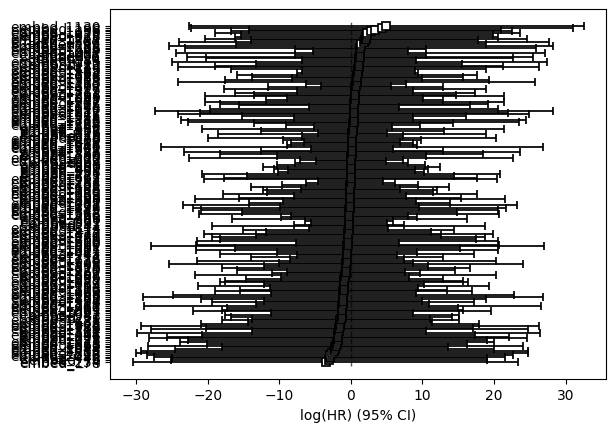

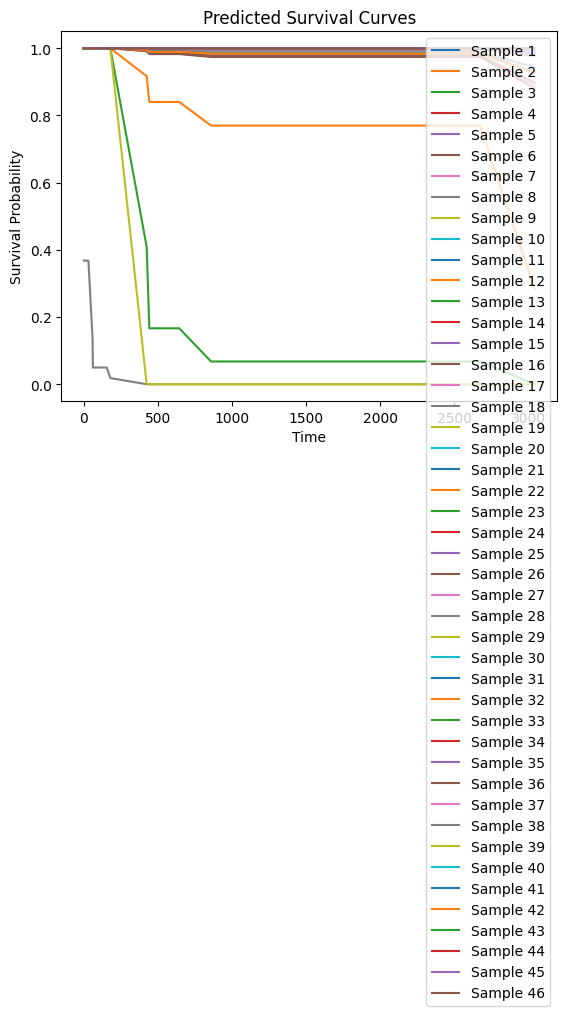

IndexError: index -1 is out of bounds for axis 0 with size 0

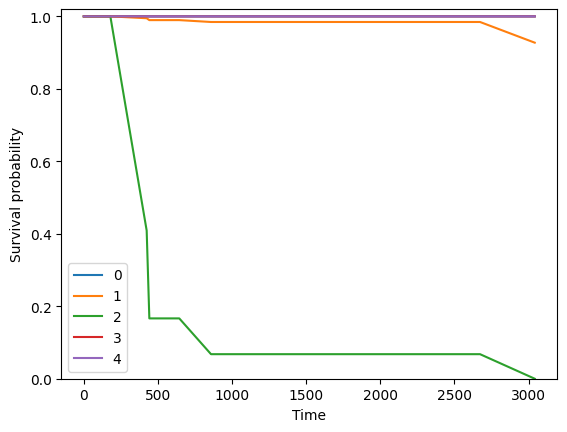

In [126]:
parquet_file = "cases_TEST_TRAIN_100/GENERAL_METADATA/consolidated_metadata_unique.parquet"
df = pd.read_parquet(parquet_file)

df["survival_time"] = df["days_to_last_followup"].fillna(df["days_to_death"])

df_clean = df[
    df["survival_time"].notnull() &
    df["embedding"].notnull() &
    df["event_occured"].notnull()
]

embeddings_expanded = pd.DataFrame(
    df_clean["embedding"].tolist(),
    columns=[f"embed_{i}" for i in range(len(df_clean["embedding"].iloc[0]))],
    index=df_clean.index
)

selector = VarianceThreshold(threshold=0.01)
high_variance_features = selector.fit_transform(embeddings_expanded)
high_variance_feature_names = embeddings_expanded.columns[selector.get_support()]
selected_features_df = pd.DataFrame(high_variance_features, columns=high_variance_feature_names, index=df_clean.index)

combined_df = pd.concat([selected_features_df, df_clean["survival_time"], df_clean["event_occured"]], axis=1)

cph = CoxPHFitter(penalizer=0.01)
cph.fit(combined_df, duration_col="survival_time", event_col="event_occured")

cph.print_summary()

cph.plot()
plt.show()

predicted_survival_curves = cph.predict_survival_function(combined_df)

for i in range(len(predicted_survival_curves.columns)):
    predicted_survival_curves.iloc[:, i].plot(label=f"Sample {i + 1}")

plt.title("Predicted Survival Curves")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

# Step 9: Evaluate the Model with LifelinesEvaluator
evl = LifelinesEvaluator(predicted_survival_curves, df_clean["survival_time"], df_clean["event_occured"])
evl.plot_survival_curves(curve_indices=[0, 1, 2, 3, 4])  # Plot the survival curves for the first 5 individuals

# Calculate Concordance Index
cindex, correct_pairs, total_pairs = evl.concordance()
print("C-index: {:.4f}; \nNumber of correctly ordered pairs: {}; \nNumber of total comparable pairs: {}.".format(
    cindex, correct_pairs, total_pairs
))